In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm 
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix, classification_report
import sklearn.preprocessing
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import selected dataset 
# from https://www.kaggle.com/datasets/basu369victor/prediction-of-asteroid-diameter?select=Asteroid_Updated.csv
data_file = 'Asteroid_Updated.csv'
asteroids = pd.read_csv(data_file, usecols = ['e', 'i', 'om', 'w', 'q', 'pha', 'moid'])

# Eliminate columns with NaN values and assign values to PHA column containing strings
asteroids = asteroids.dropna().reset_index(drop=True)
asteroids.pha[asteroids.pha =='N'] = 0.
asteroids.pha[asteroids.pha =='Y'] = 1.

In [3]:
asteroid_df = pd.DataFrame({'e':asteroids['e'], 
                               'i':asteroids['i'],
                               'om':asteroids['om'],
                               'w':asteroids['w'],
                               'q':asteroids['q'], 
                               'moid':asteroids['moid'],
                               'pha':asteroids['pha']}) 

# Make sure the PHA values are floats to be interpreted properly
asteroid_df['pha']=asteroid_df['pha'].astype('float') 

# Shuffle the dataset
asteroid_df = asteroid_df.sample(frac=1)

Text(0, 0.5, 'Count')

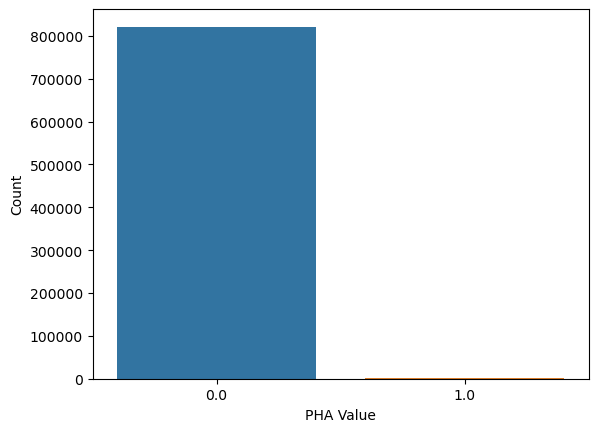

In [4]:
# Plot the imbalance of the dataframe PHA values
sns.countplot(asteroid_df['pha'])
plt.xlabel('PHA Value')
plt.ylabel('Count')

In [5]:
# Creating the undersampled dataset (including MOID)

phaones = asteroid_df[asteroid_df['pha'] == 1.]
phazeros = asteroid_df[asteroid_df['pha'] == 0.][0:len(phaones)]
undersample = pd.concat([phazeros, phaones], axis=0)

In [6]:
# Creating the oversampled dataset (including MOID)

xs = asteroid_df.iloc[:, [0, 1, 2, 3, 4, 5]] 
whole_xs = sklearn.preprocessing.RobustScaler().fit_transform(xs) 
whole_ys = asteroid_df['pha']

# Use SMOTE to oversample the 1's in the PHA column
smote = SMOTE(sampling_strategy="minority")
whole_xs, whole_ys = smote.fit_resample(whole_xs, whole_ys)

#Recombine the inputs and outputs into a singular dataframe
oversample = pd.DataFrame(whole_xs)
oversample.loc[:,'pha'] = whole_ys

In [7]:
def TrainTestData(dataset, moidvalue):
    """
    Performs train-test split on desired dataset with or without MOID
    
    Args:
    dataset (dataframe): desired dataset
    moidvalue (int): 1 or 0, to include MOID values or not, respectively
    
    Returns:
    x_train, x_test, y_train, y_test (arrays): Test and train data split into inputs (x) and outputs (y)
    
    """
    if moidvalue == 0:
        x_values = dataset.iloc[:, [0, 1, 2, 3, 4]]
    elif moidvalue == 1:
        x_values = dataset.iloc[:, [0, 1, 2, 3, 4, 5]]
        
    # Normalize the input data
    x_values = sklearn.preprocessing.RobustScaler().fit_transform(x_values)
    
    # Perform a 80:20 train-test split
    x_train, x_test, y_train, y_test = train_test_split(x_values, dataset['pha'].values.flatten(), test_size=0.2)
    
    return x_train, x_test, y_train, y_test

In [8]:
def MLTechniques(dataset, moidvalue, technique):   
    """
    Perform machine learning prediction techniques on a given dataset.
    
    Args:
    dataset (dataframe): desired dataset
    moidvalue (int): 1 or 0, to include MOID values or not, respectively
    technique (str): 'SVM', 'RandomForest', or 'GradientBoost' to select ML prediction technique
    
    Returns:
    cm (array): Confusion Matrix for given dataset and technique
    
    Note: if using entire dataset, some techniques may be computationally expensive
    """
    x_train, x_test, y_train, y_test = TrainTestData(dataset, moidvalue)
    
    if technique == 'SVM': 
        # Train the Support Vector Machine (svm) 
        svc = svm.SVC(kernel='linear')
        model = svc.fit(x_train, y_train)
        predicted_labels = svc.predict(x_test)
        
    elif technique == 'RandomForest':
        # Train Random Forest Regressor
        rf = RandomForestRegressor()
        model = rf.fit(x_train, y_train)
        predicted_labels = rf.predict(x_test)
        
    elif technique == 'GradientBoost':
        # Train Gradient Boosting Regressor
        gb = GradientBoostingRegressor()
        model = gb.fit(x_train, y_train)
        predicted_labels = gb.predict(x_test)
        
    print(classification_report(y_test, predicted_labels.round()))
    
    # Plot the confusion matrix
    cm = confusion_matrix(y_test, predicted_labels.round(), labels=[0., 1.])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=[0., 1.])
    disp.plot()
    plt.show()
    
    return cm

### Examples of oversampled and undersampled results for different below:

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.99       413
         1.0       0.97      1.00      0.99       393

    accuracy                           0.99       806
   macro avg       0.99      0.99      0.99       806
weighted avg       0.99      0.99      0.99       806



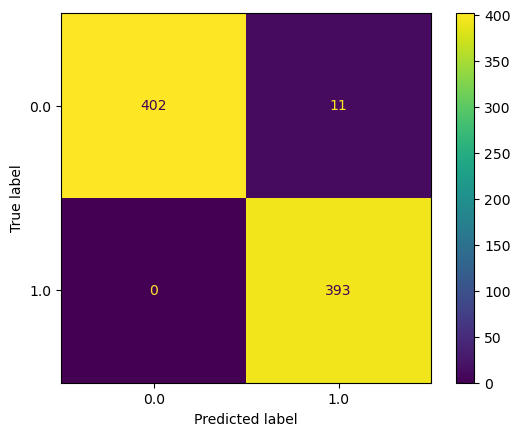

array([[402,  11],
       [  0, 393]], dtype=int64)

In [9]:
MLTechniques(undersample, 1, 'SVM')

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       390
         1.0       0.99      1.00      0.99       416

    accuracy                           0.99       806
   macro avg       0.99      0.99      0.99       806
weighted avg       0.99      0.99      0.99       806



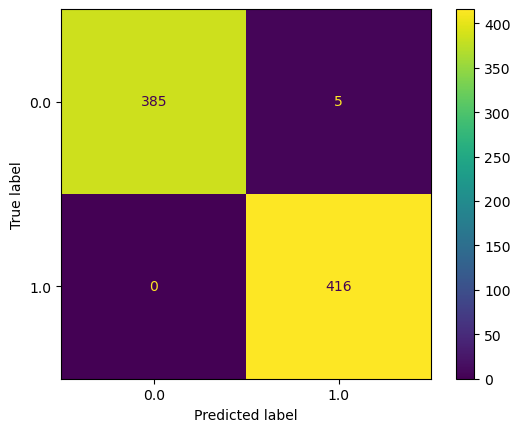

array([[385,   5],
       [  0, 416]], dtype=int64)

In [10]:
MLTechniques(undersample, 0, 'RandomForest')

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99    164391
         1.0       0.98      1.00      0.99    164112

    accuracy                           0.99    328503
   macro avg       0.99      0.99      0.99    328503
weighted avg       0.99      0.99      0.99    328503



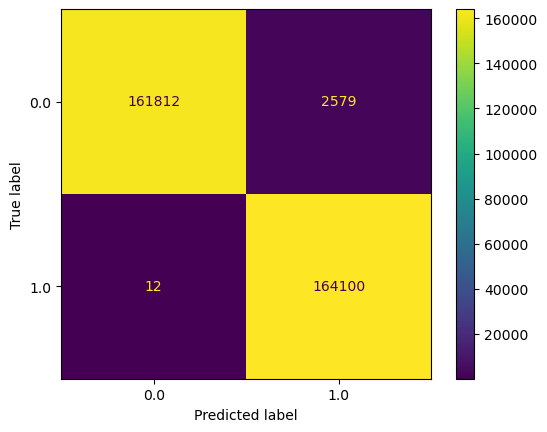

array([[161812,   2579],
       [    12, 164100]], dtype=int64)

In [11]:
MLTechniques(oversample, 0, 'GradientBoost')

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00    164035
         1.0       0.99      1.00      1.00    164468

    accuracy                           1.00    328503
   macro avg       1.00      1.00      1.00    328503
weighted avg       1.00      1.00      1.00    328503



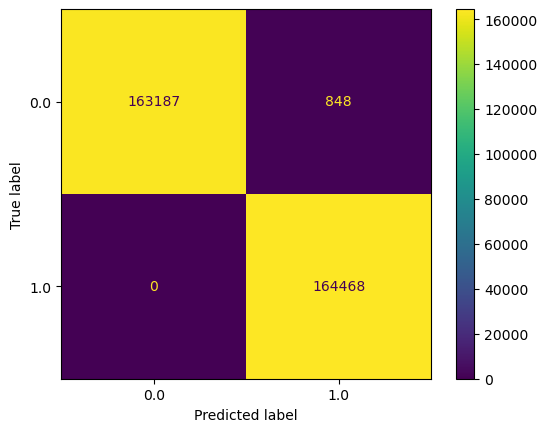

array([[163187,    848],
       [     0, 164468]], dtype=int64)

In [12]:
MLTechniques(oversample, 1, 'RandomForest')